In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns





In [34]:
def load_data(assignment3dataset):
    with open(assignment3dataset, 'r',encoding='utf-8') as f:
        raw = f.read()
    sentences = raw.strip().split('\n\n')
    tokenised_data = []
    for sentence in sentences:
        words = [line.split() for line in sentence.splitlines() if len(line.split()) == 2]
        if not words :
            continue
        tokens, tags = zip(*words)
        tokenised_data.append((list(tokens), list(tags)))
    return tokenised_data
    
  
        

In [35]:
def build_vocab(sequences, min_freq=1):
    counter = Counter()
    for seq in sequences:
        counter.update(seq)
    
    vocab = {'<pad>': 0, '<unk>': 1}  
    
    for token, count in counter.items():
        if count >= min_freq:
            vocab[token] = len(vocab)
    
    return vocab


In [36]:
def encode_sequence(seq, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in seq]
def pad_sequence(seq, max_len , pad_value):
    return seq + [pad_value] * (max_len - len(seq))


In [37]:
class NERDataset(Dataset):
    def __init__(self, data, word2idx , tag2idx):
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len =max(len(seq) for seq , _ in data)
        self.sentences =[pad_sequence (encode_sequence (s,word2idx),self.max_len,word2idx['<pad>']) for s, _ in data]
        self.labels =[pad_sequence(encode_sequence(t,tag2idx), self.max_len,tag2idx['<pad>']) for _,t in data]
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]), torch.tensor(self.labels[idx])
    
data = load_data('assignment3dataset.txt')
sentences, tags = zip(*data)
    
word2idx = build_vocab(sentences)
tag2idx = build_vocab(tags)
tag2idx['<PAD>'] = 0
idx2tag ={i: tag for tag , i in tag2idx.items()}


In [38]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataset = NERDataset(train_data, word2idx, tag2idx)
val_dataset = NERDataset(val_data, word2idx, tag2idx)
test_dataset = NERDataset(test_data, word2idx, tag2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [39]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=100, hidden_dim=128):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_dim, tagset_size)


    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        logits = self.fc(out)
        return logits

In [41]:
class TransformerNER(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=128, nhead=8, num_layers=2):
        super(TransformerNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.randn(1, 512, emb_dim))  # Max 512 tokens
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(emb_dim, tagset_size)
    
    def forward(self, x):
        seq_len = x.size(1)
        emb = self.embedding(x) + self.pos_embedding[:, :seq_len, :]
        out = self.transformer(emb)
        logits = self.fc(out)
        return logits


In [42]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out.view(-1, out.shape[-1]), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                out = model(x)
                loss = criterion(out.view(-1, out.shape[-1]), y.view(-1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.show()
    return model

Epoch 1/10 - Train Loss: 1.0061 - Val Loss: 0.6996
Epoch 2/10 - Train Loss: 0.6098 - Val Loss: 0.6373
Epoch 3/10 - Train Loss: 0.5417 - Val Loss: 0.5915
Epoch 4/10 - Train Loss: 0.4718 - Val Loss: 0.5414
Epoch 5/10 - Train Loss: 0.3998 - Val Loss: 0.5061
Epoch 6/10 - Train Loss: 0.3337 - Val Loss: 0.4830
Epoch 7/10 - Train Loss: 0.2737 - Val Loss: 0.4654
Epoch 8/10 - Train Loss: 0.2179 - Val Loss: 0.4628
Epoch 9/10 - Train Loss: 0.1706 - Val Loss: 0.4536
Epoch 10/10 - Train Loss: 0.1358 - Val Loss: 0.4660


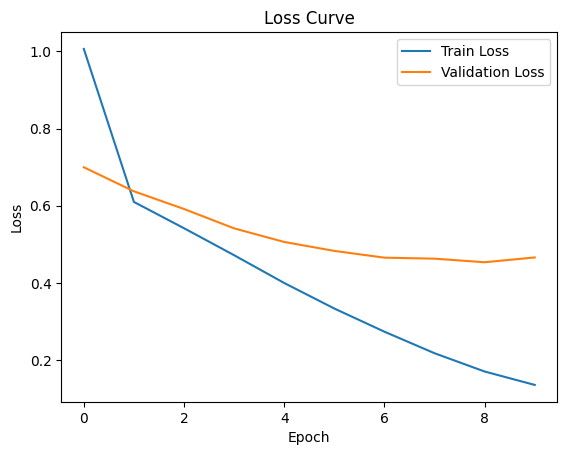

              precision    recall  f1-score   support

       <unk>       0.00      0.00      0.00         0
      I-MISC       0.27      0.23      0.25       132
           O       0.92      0.97      0.94      3435
       I-ORG       0.63      0.32      0.42       194
       I-PER       0.51      0.48      0.50       151
       I-LOC       0.60      0.37      0.46       185

    accuracy                           0.87      4097
   macro avg       0.49      0.40      0.43      4097
weighted avg       0.85      0.87      0.86      4097



c:\Users\ACER\anaconda3\envs\work\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\anaconda3\envs\work\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\anaconda3\envs\work\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\

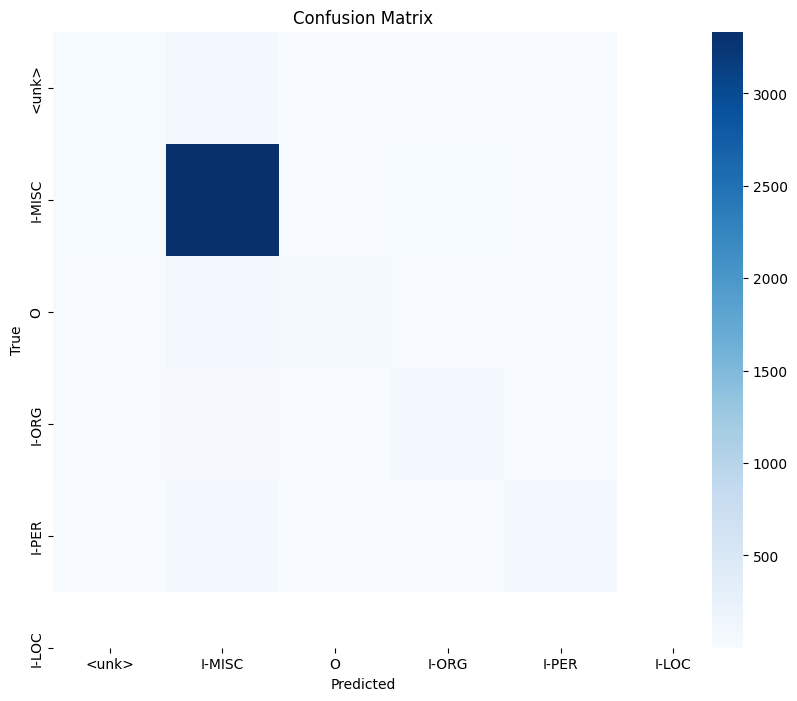

In [44]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in dataloader:
            out = model(x)
            pred = out.argmax(dim=-1)
            for true_seq, pred_seq in zip(y, pred):
                for true_tag, pred_tag in zip(true_seq, pred_seq):
                    if true_tag.item() != tag2idx['<PAD>']:
                        y_true.append(true_tag.item())
                        y_pred.append(pred_tag.item())
                        
    labels = [i for i in sorted(idx2tag) if i != tag2idx['<PAD>']]
    target_names = [idx2tag[i] for i in labels]
    print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', xticklabels=[idx2tag[i] for i in sorted(idx2tag) if i != tag2idx['<PAD>']],
                yticklabels=[idx2tag[i] for i in sorted(idx2tag) if i != tag2idx['<PAD>']], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Instantiate and train the BiLSTM model
vocab_size = len(word2idx)
tagset_size = len(tag2idx)
model = BiLSTMTagger(vocab_size, tagset_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx['<PAD>'])

trained_model = train_model(model, train_loader, val_loader, optimizer, criterion)

# Evaluate the best model on test set
evaluate_model(trained_model, test_loader)